In [1]:
# utils
import scipy
import skbio
import qiime2
import itertools
import pandas as pd
import scipy.stats as ss
from qiime2.plugins import diversity, feature_table
from scipy.spatial import ConvexHull
# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex
import pingouin as pg

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import metadata
md = qiime2.Metadata.load('../T1_SMDS_metadata_ms.txt').to_dataframe()
# create column that uniquely has participant/prcess (group from which to calculate convex hull)
md['participant_process'] = md['participant_id'] + md['processing']

### Run convex hull analysis on Unweighted Unifrac plot

In [12]:
# import PCoA on which to calculate convex hull
subset_pc = qiime2.Artifact.load('../SMDS_unweighted_unifrac_pcoa.qza')    
# get ordination results
pc = subset_pc.view(skbio.OrdinationResults)

In [13]:
# pull out first 3 axes and calculate convex hull by group of interest
ndims = 3
site_person_ch = []
for person, person_grp in md.groupby('participant_process'):
    coords = pc.samples.loc[person_grp.index].values[:, :ndims]
    ch = ConvexHull(coords)
    site_person_ch.append([person, ch.volume, ch.area]) 

site_person_ch = pd.DataFrame(site_person_ch, 
                              columns=['participant_process', 'convexhull_volume', 'convexhull_area'])


In [14]:
# merge volume results with metadata
md_20 = md.drop_duplicates(subset=['participant_process'])
ch = pd.merge(site_person_ch, md_20, left_on='participant_process', right_on='participant_process', how='left')
ch.columns

Index(['participant_process', 'convexhull_volume', 'convexhull_area',
       'study_acronym', 'experiment_name', 'participant_id', 'saliva_weight_g',
       'saliva_volume_mL_collected_in_5_min', 'saliva_flow_rate_mL_per_min',
       'FC_cells_per_ul_r1', 'FC_cells_per_ul_r2', 'FC_avg_cells_per_ul',
       'FC_avg_cells_5_min', 'processing', 'collection_time_stamp', 'gender',
       'age', 'saliva_sample_ID', 'timepoint', 'mouthwash_regularly?',
       'qPCR_median_16S_copies_per_2ul_DNA', 'alcohol_since_last_sample',
       'misc-notes', 'food', 'food notes', 'drink notes',
       'self_reported_min_brushing', 'floss_regularly?', 'toothbrush_type',
       'percent_reads_aligning_to_chloroplast_seqeuneces'],
      dtype='object')

(0.0, 0.11)

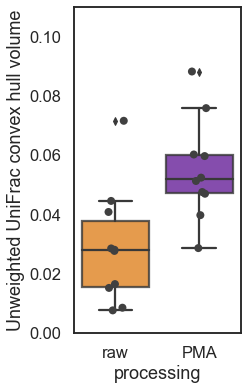

In [15]:
order = ['raw','PMA']
sns.set_style('white')
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(3,6))
sns.boxplot(y='convexhull_area',x='processing', data=ch, ax=ax, order=order, notch=False,
            palette=['#FF8300','#6A0DAD'], boxprops=dict(alpha=.8))
sns.stripplot(y='convexhull_area',x='processing', data=ch, color='.25', size=8, ax=ax, order=order)
ax.set_ylabel('Unweighted UniFrac convex hull volume')
ax.set_ylim(0,0.11)

In [10]:
#fig.savefig('../../figures/convex_hull.png', bbox_inches='tight', dpi=500)

In [11]:
# calculate paired t-test statistic
pma = ch[ch['processing']=='PMA'].convexhull_volume
raw = ch[ch['processing']=='raw'].convexhull_volume
ss.ttest_rel(pma, raw)

Ttest_relResult(statistic=2.5194429087758587, pvalue=0.03279861706706853)